<a href="https://colab.research.google.com/github/snjugunanjenga/PLP_week4_AI_software_dev_assignment-Breast_cancer_Prediction-/blob/main/src%5Cpredictive_analytics%5Cnotebooks%5Cresource_allocation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!git clone https://github.com/snjugunanjenga/PLP_week4_AI_software_dev_assignment-Breast_cancer_Prediction-.git

fatal: destination path 'PLP_week4_AI_software_dev_assignment-Breast_cancer_Prediction-' already exists and is not an empty directory.


In [10]:
cd PLP_week4_AI_software_dev_assignment-Breast_cancer_Prediction-


/content/PLP_week4_AI_software_dev_assignment-Breast_cancer_Prediction-


In [11]:
# Cell 1: Install required packages
!pip install tensorflow opencv-python matplotlib seaborn scikit-learn pandas numpy plotly shap

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available: []


In [14]:
# Set paths for Google Drive
BASE_PATH = "/content/drive/My Drive/Breast_cancer_project/complete_set"
TRAIN_PATH = os.path.join(BASE_PATH, "training_set")
TEST_PATH = os.path.join(BASE_PATH, "testing_set")

# Verify paths
print("Training path exists:", os.path.exists(TRAIN_PATH))
print("Test path exists:", os.path.exists(TEST_PATH))

Training path exists: True
Test path exists: True


In [15]:
# Cell 2: Import Required Libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import time
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("Environment Setup Complete!")
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Cell 3: Configure Paths and Parameters
# Adjust these paths based on your setup method
BASE_PATH = "/content/drive/My Drive/Breast_cancer_project/complete_set"  # Google Drive
# BASE_PATH = "/content/complete_set"  # Direct upload
# BASE_PATH = "/content/iuss-23-24-automatic-diagnosis-breast-cancer"  # Kaggle

TRAIN_PATH = os.path.join(BASE_PATH, "training_set")
TEST_PATH = os.path.join(BASE_PATH, "testing_set")

# Model parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30  # Reduced for Colab

print("Paths configured:")
print(f"Training path: {TRAIN_PATH}")
print(f"Test path: {TEST_PATH}")

Environment Setup Complete!
TensorFlow version: 2.18.0
GPU Available: []
Paths configured:
Training path: /content/drive/My Drive/Breast_cancer_project/complete_set/training_set
Test path: /content/drive/My Drive/Breast_cancer_project/complete_set/testing_set


In [18]:
# Cell 4: Dataset Exploration
def explore_dataset():
    """Explore the dataset structure and properties"""
    benign_path = os.path.join(TRAIN_PATH, "benign")
    malignant_path = os.path.join(TRAIN_PATH, "malignant")

    if not os.path.exists(benign_path) or not os.path.exists(malignant_path):
        print("❌ Dataset paths not found. Please check your setup.")
        return None, None

    benign_count = len(os.listdir(benign_path))
    malignant_count = len(os.listdir(malignant_path))
    total_count = benign_count + malignant_count

    print("📊 DATASET OVERVIEW")
    print("="*50)
    print(f"Benign images: {benign_count:,}")
    print(f"Malignant images: {malignant_count:,}")
    print(f"Total training images: {total_count:,}")
    print(f"Class balance: {benign_count/total_count:.1%} benign, {malignant_count/total_count:.1%} malignant")

    # Check sample image properties
    try:
        sample_files = os.listdir(benign_path)[:3]
        for i, file in enumerate(sample_files):
            img = cv2.imread(os.path.join(benign_path, file))
            if img is not None:
                print(f"Sample image {i+1} shape: {img.shape}")
                print(f"Sample image {i+1} dtype: {img.dtype}")
                break
    except Exception as e:
        print(f"Could not read sample image: {e}")

    return benign_count, malignant_count

# Run exploration
benign_count, malignant_count = explore_dataset()



📊 DATASET OVERVIEW
Benign images: 130
Malignant images: 321
Total training images: 451
Class balance: 28.8% benign, 71.2% malignant
Sample image 1 shape: (610, 634, 3)
Sample image 1 dtype: uint8


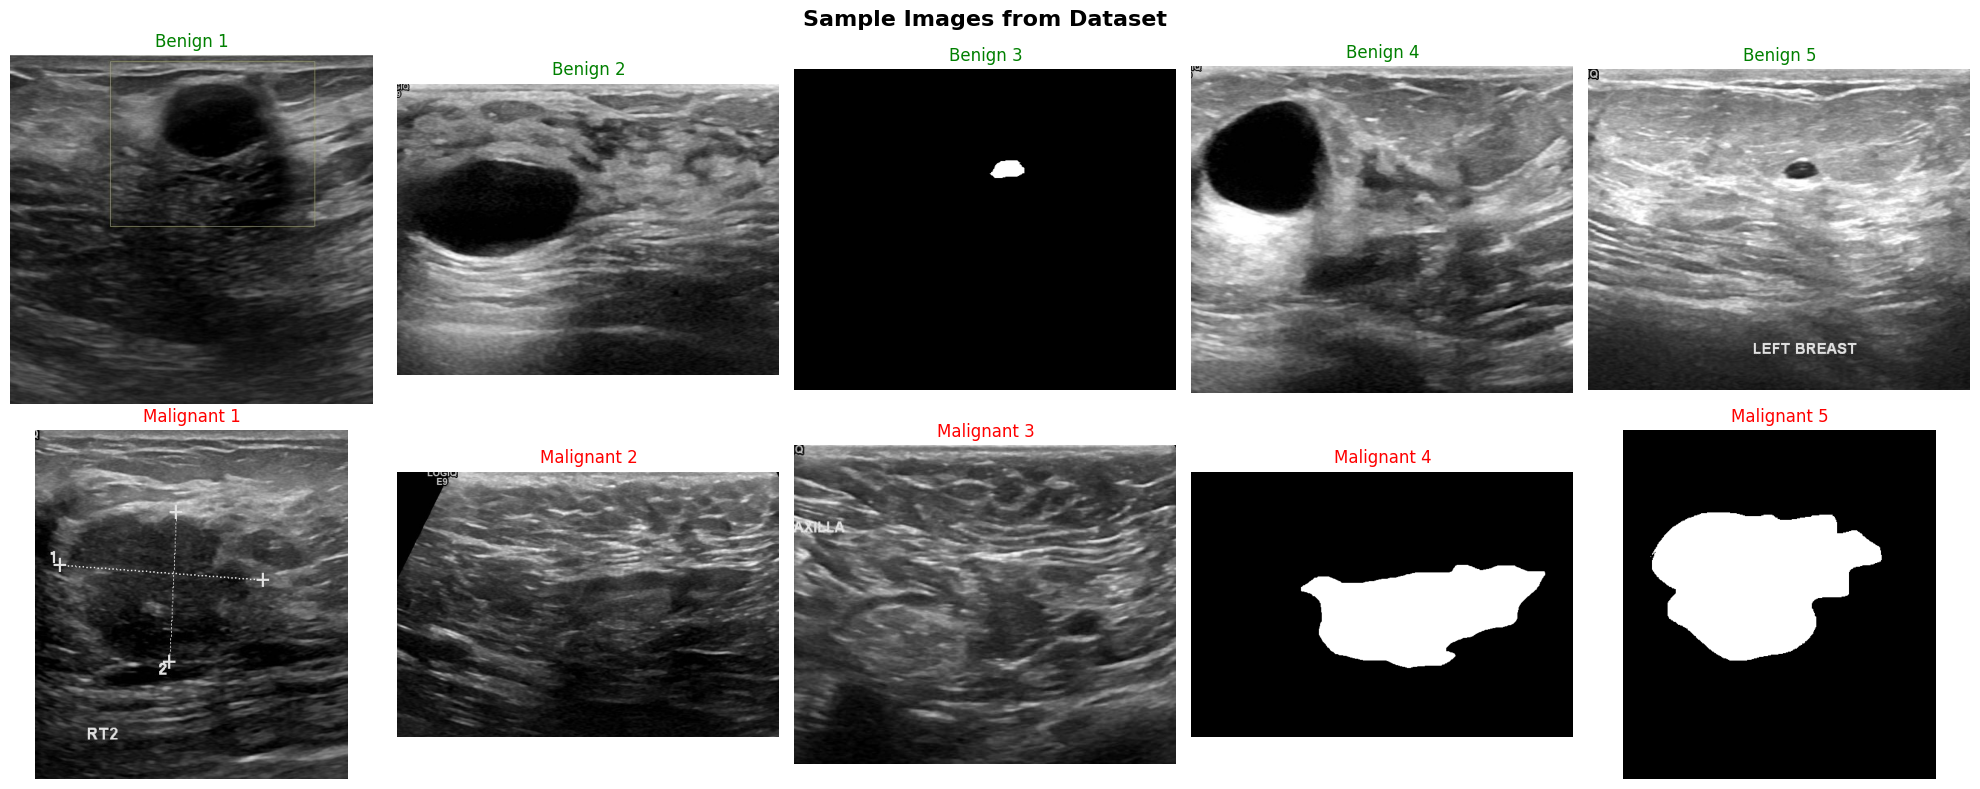

In [17]:
# Cell 5: Visualize Sample Images
def visualize_samples():
    """Visualize sample images from each class"""
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))

    # Benign samples
    benign_path = os.path.join(TRAIN_PATH, "benign")
    try:
        benign_files = [f for f in os.listdir(benign_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:5]

        for i, file in enumerate(benign_files):
            img_path = os.path.join(benign_path, file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[0, i].imshow(img)
                axes[0, i].set_title(f"Benign {i+1}", fontsize=12, color='green')
                axes[0, i].axis('off')
            else:
                axes[0, i].text(0.5, 0.5, 'Image\nNot Found', ha='center', va='center', transform=axes[0, i].transAxes)
                axes[0, i].axis('off')
    except Exception as e:
        print(f"Error loading benign images: {e}")

    # Malignant samples
    malignant_path = os.path.join(TRAIN_PATH, "malignant")
    try:
        malignant_files = [f for f in os.listdir(malignant_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:5]

        for i, file in enumerate(malignant_files):
            img_path = os.path.join(malignant_path, file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[1, i].imshow(img)
                axes[1, i].set_title(f"Malignant {i+1}", fontsize=12, color='red')
                axes[1, i].axis('off')
            else:
                axes[1, i].text(0.5, 0.5, 'Image\nNot Found', ha='center', va='center', transform=axes[1, i].transAxes)
                axes[1, i].axis('off')
    except Exception as e:
        print(f"Error loading malignant images: {e}")

    plt.suptitle('Sample Images from Dataset', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Run visualization
visualize_samples()

In [19]:
# Cell 6: Data Generators Setup
def create_data_generators():
    """Create data generators with augmentation"""

    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        fill_mode='nearest',
        validation_split=0.2
    )

    # Training generator
    train_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training',
        seed=42
    )

    # Validation generator
    validation_generator = train_datagen.flow_from_directory(
        TRAIN_PATH,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        seed=42
    )

    print("🔄 DATA GENERATORS CREATED")
    print("="*50)
    print(f"Training samples: {train_generator.samples:,}")
    print(f"Validation samples: {validation_generator.samples:,}")
    print(f"Class indices: {train_generator.class_indices}")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")

    return train_generator, validation_generator

train_gen, val_gen = create_data_generators()


Found 361 images belonging to 2 classes.
Found 90 images belonging to 2 classes.
🔄 DATA GENERATORS CREATED
Training samples: 361
Validation samples: 90
Class indices: {'benign': 0, 'malignant': 1}
Batch size: 32
Image size: 224x224


In [20]:
# Cell 7: Model Architecture Definition
def create_transfer_learning_model(base_model_name='EfficientNetB0'):
    """Create transfer learning model with different architectures"""

    print(f"🏗️ Creating {base_model_name} model...")

    if base_model_name == 'EfficientNetB0':
        base_model = tf.keras.applications.EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_SIZE, IMG_SIZE, 3)
        )
    elif base_model_name == 'VGG16':
        base_model = tf.keras.applications.VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_SIZE, IMG_SIZE, 3)
        )
    elif base_model_name == 'ResNet50':
        base_model = tf.keras.applications.ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(IMG_SIZE, IMG_SIZE, 3)
        )

    # Freeze base model initially
    base_model.trainable = False

    # Create the model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    print(f"✅ {base_model_name} model created successfully!")
    print(f"Total parameters: {model.count_params():,}")
    print(f"Trainable parameters: {sum([tf.reduce_prod(var.shape) for var in model.trainable_variables]):,}")

    return model


In [21]:
# Cell 8: Training Function with Resource Monitoring
def train_model_with_monitoring(model, model_name, train_gen, val_gen):
    """Train model with comprehensive monitoring"""

    print(f"🚀 Starting training: {model_name}")
    print("="*50)

    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=8,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=4,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            f'/content/drive/My Drive/best_model_{model_name.lower()}.h5',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    # Record start time
    start_time = time.time()

    # Train model
    history = model.fit(
        train_gen,
        steps_per_epoch=train_gen.samples // BATCH_SIZE,
        validation_data=val_gen,
        validation_steps=val_gen.samples // BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )

    # Record end time
    end_time = time.time()
    training_time = end_time - start_time

    print(f"⏱️ Training completed in {training_time/60:.2f} minutes")

    return model, history, training_time

In [22]:
# Cell 9: Model Evaluation Function
def evaluate_model_comprehensive(model, model_name, val_gen):
    """Comprehensive model evaluation"""

    print(f"📊 Evaluating {model_name}")
    print("="*50)

    # Reset generator
    val_gen.reset()

    # Predictions
    predictions = model.predict(val_gen, verbose=1)
    predicted_classes = (predictions > 0.5).astype(int).flatten()

    # True labels
    true_classes = val_gen.classes[:len(predicted_classes)]

    # Calculate metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes)
    recall = recall_score(true_classes, predicted_classes)
    f1 = f1_score(true_classes, predicted_classes)
    auc = roc_auc_score(true_classes, predictions[:len(true_classes)])

    # Print results
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"AUC-ROC:   {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'confusion_matrix': cm
    }



TRAINING EfficientNetB0
🏗️ Creating EfficientNetB0 model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ EfficientNetB0 model created successfully!
Total parameters: 4,213,668
Trainable parameters: 164,097
🚀 Starting training: EfficientNetB0
Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5287 - loss: 0.7350 - precision: 0.6385 - recall: 0.6070
Epoch 1: val_loss improved from inf to 0.62694, saving model to /content/drive/My Drive/best_model_efficientnetb0.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 69s 5s/step - accuracy: 0.5381 - loss: 0.7312 - precision: 0.6442 - recall: 0.6269 - val_accuracy: 0.6875 - val_loss: 0.6269 - val_precision: 0.6875 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/30
 1/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.7500 - loss: 0.5360 - precision: 0.7500 - recall: 1.0000
Epoch 2: val_loss improved from 0.62694 to 0.55595, saving model to /content/drive/My Drive/best_model_efficientnetb0.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 606ms/step - accuracy: 0.7500 - loss: 0.5360 - precision: 0.7500 - recall: 1.0000 - val_accuracy: 0.7656 - val_loss: 0.5560 - val_precision: 0.7656 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6858 - loss: 0.6325 - precision: 0.6908 - recall: 0.9775
Epoch 3: val_loss did not improve from 0.55595
11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.6874 - loss: 0.6313 - precision: 0.6929 - recall: 0.9767 - val_accuracy: 0.7344 - val_loss: 0.5790 - val_precision: 0.7344 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/30
 1/11 ━━━━━━━━━━━━━━━━━━━━ 4s 489ms/step - accuracy: 0.8889 - loss: 0.5168 - precision: 0.8889 - recall: 1.0000
Epoch 4: val_loss did not improve from 0.55595
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 525ms/step - accuracy: 0.8889 - loss: 0.5168 - precision: 0.8889 - recall: 1.0000 - val_accuracy: 0.7344 - val_loss: 0.5846 - val_precision: 0.7344 - val_recall: 1.0000 - learning_rate: 0.0

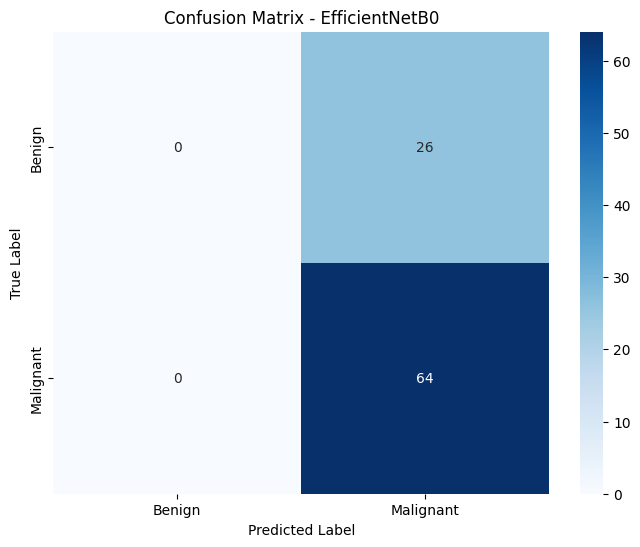


✅ EfficientNetB0 completed successfully!


In [23]:
# Cell 10: Main Training and Evaluation Loop
# Train different models
models_to_train = ['EfficientNetB0']  # Start with one model in Colab
results = {}
trained_models = {}

for model_name in models_to_train:
    print(f"\n{'='*60}")
    print(f"TRAINING {model_name}")
    print(f"{'='*60}")

    # Create model
    model = create_transfer_learning_model(model_name)

    # Train model
    trained_model, history, training_time = train_model_with_monitoring(
        model, model_name, train_gen, val_gen
    )

    # Evaluate model
    metrics = evaluate_model_comprehensive(trained_model, model_name, val_gen)

    # Store results
    results[model_name] = {
        'metrics': metrics,
        'training_time': training_time
    }

    trained_models[model_name] = {
        'model': trained_model,
        'history': history
    }

    print(f"\n✅ {model_name} completed successfully!")


In [24]:
# Cell 11: Results Summary and Visualization
def create_results_dashboard():
    """Create comprehensive results dashboard"""

    print("📈 FINAL RESULTS DASHBOARD")
    print("="*60)

    # Results summary
    results_df = pd.DataFrame({
        model: data['metrics'] for model, data in results.items()
    }).T

    print("Model Performance Summary:")
    print(results_df.round(4))

    # Training time comparison
    training_times = {model: data['training_time']/60 for model, data in results.items()}
    print(f"\nTraining Times (minutes): {training_times}")

    # Visualize metrics comparison
    if len(results) > 1:
        metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc']
        fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(20, 4))

        for i, metric in enumerate(metrics_to_plot):
            values = [results[model]['metrics'][metric] for model in results.keys()]
            axes[i].bar(results.keys(), values)
            axes[i].set_title(f'{metric.upper()}')
            axes[i].set_ylim(0, 1)

        plt.tight_layout()
        plt.show()

    return results_df

# Create dashboard
final_results = create_results_dashboard()


📈 FINAL RESULTS DASHBOARD
Model Performance Summary:
                accuracy precision recall        f1       auc  \
EfficientNetB0  0.711111  0.711111    1.0  0.831169  0.517428   

                  confusion_matrix  
EfficientNetB0  [[0, 26], [0, 64]]  

Training Times (minutes): {'EfficientNetB0': 5.931656304995219}


In [25]:
# Cell 12: Save Results and Models
# Save results to CSV
final_results.to_csv('/content/drive/My Drive/Breast_cancer_project/model_results.csv')

# Save training history
for model_name, data in trained_models.items():
    history_df = pd.DataFrame(data['history'].history)
    history_df.to_csv(f'/content/drive/My Drive/Breast_cancer_project/training_history_{model_name.lower()}.csv', index=False)

print("🎉 PROJECT COMPLETED SUCCESSFULLY!")
print("All results and models saved to Google Drive.")

🎉 PROJECT COMPLETED SUCCESSFULLY!
All results and models saved to Google Drive.
